# Introduction: Vector representation for Brazilian Occupation Code - CBO

In this notebook, we will build a vector representation for Brazilian Code of Occupations - CBO based on the idea that different occupation codes that are related to similar activities must have vector representation next to each other. In order to create this representation of occupation codes, we'll use the concept of neural network entity embeddings, mapping each occupation and each activity to a 50-number vector. 

The proposal of this work  is to represent high-dimensional categorical variables as low-dimensional _learned_ representation that _places similar entities closer together in the embedding space_. Traditional techiniques like one-hot-encode the CBO codes (another representation of categorical data) we would have a 2,666 dimension vector for each CBO code, with a single 1 indicating the CBO. In a one-hot encoding, similar codes would not be "closer" to one another. By  training a neural network to learn entity embeddings, we not only get a reduced dimension representation of the CBO codes, we also get a representation that _keeps similar CBO codes closer to each other_. Therefore, the basic approach for separating workers into groups based on their individual characteristics in order to define more appropriate treatments for each group depends on,among other information, on those related to previous work experience, and bearing in mind that information about work experience is coded in databases used by Brazilian Federal Government as a CBO code,  it's necessary to create entity embeddings of all the CBO's, and then be able to use adequatelly the resulting embedding in machine learning tasks. 

## Information about the domain

In Brazil, all working experiences are registered in the Annual Relation of Social Information (RAIS), an administrative register maintained by the Ministry of Economy (ME). Personal characteristics of workers and information about the employment relationships are compulsorily offered by all formally registered, public or private companies in the country. 

The set of activities potentially performed in the context of a given employment relationship are represented at RAIS by means of a code, the Brazilian Code of Occupations (CBO). The CBO code is a 6-digit word where the first digit identify 10 groups and the first two,three and four digits represents respectively 49 sub-major groups, 195 minor groups and 625 unit groups of occupations. This structure are based on 1998's International Standard Classification of Occupation (ISCO-88), which was designed to allow statistical comparability of labor market data of different countries. Information regarding to sub-major groups, minor groups, unit groups, codes in addition to the set of activities potentially performed in the context of a given CBO can be consulted at Ministry of Economy page ( [Estrutura CBO (CSV)](http://www.mtecbo.gov.br/cbosite/pages/downloads.jsf) ).



Although the use of the CBO code reduces the complexity of analyzing the possible activities that can be performed in an employment relationship by grouping them into only 2666 codes, it is still necessary to prepare this categorical variable for future use by machine learning algorithms. Traditional techniques, like one-hot-encoding, would result in loss of information, as there is different levels of proximity between CBOs and one-hot-encoding transforms categorical variables into a n-dimensional vector where each distinct category has the same distance from all others codes.



## Approach

To create entity embeddings, we need to build an embedding neural network and train it on a supervised machine learning task that will result in similar CBO's (and similar activities) having closer representations in embedding space. The parameters of the neural network - the weights - are the embeddings, and so during training, these numbers are adjusted to minimize the loss on the prediction problem. In other words, the network tries to accurately complete the task by changing the representation of the CBO codes. 

Once we have the embeddings for the CBO's and the activities, we can find the most similar CBO to a given CBO by computing the distance between the embedded vector for that CBO and all the other CBO embeddings. We'll use the cosine distance which measures the angle between two vectors as a measure of similarity. The steps we will follow are:

1. Load in data and clean
2. Prepare data for supervised machine learning task
3. Build the entity embedding neural network
4. Train the neural network on prediction task
5. Extract embeddings 
6. Visualize the embeddings using dimension reduction techniques 

### Supervised Machine Learning Task: Map CBO codes to Activities

For our machine learning task, we'll set up the problem as identifying whether or not a particular activity is related to a CBO code. The training examples will consist of (cbo, activities) pairs, with some pairs true examples - actually  in the data - and others negative examples - occupations that are not linked to the activity. It will be the network's job to adjust the entity embeddings of the CBO codes and the activities in order to accurately make this classification. Although we are training for a supervised machine learning task, our end objective is not to make accurate predictions on new data, but learn the best entitiy embeddings, so we do not use a validation or testing set. We use the prediction problem as a means to an end rather than the final outcome. 

## Neural Network Embeddings

Neural Network embeddings have proven to be very powerful concepts both for modeling language and for representing categorical variables. For example, the [Word2Vec word embeddings](https://www.tensorflow.org/tutorials/representation/word2vec) map a word to a vector based on training a neural network on millions of words. These embeddings can be used in any supervised model because they are just numerical representations of categorical variables. Much as we one-hot-encode categorical variables to use them in a random forest for a supervised task, we can also use entity embeddings to include categorical variables in a model. The embeddings are also useful because we can find entities that are close to one another in embedding space which might allow us to find the most similar categories among tens of thousands of choices. 

We can also use the Entity Embeddings to visualize words or categorical variables, such as creating a map of all previous working experiences of a particular individual. The entity embeddings typically are still high-dimensional - we'll use 50 numbers for each entity - so we need to use a dimension reduction technique such as TSNE or UMAP to visualize the embeddings in lower dimensions. (These are both manifold embedding methods so in effect we will embed the embeddings for visualization!) We'll take a look at doing this at the end of the notebook and later will upload the embeddings into a application custom-built for this purpose ([projector.tensorflow.org](https://projector.tensorflow.org)). Entity embeddings are becoming more widespread thanks to the ease of development of neural networks in Keras and are a useful approach when we want to represent categorical variables with vectors that place similar categories close to one another. Other approaches for encoding categorical variables do not represent similar entities as being closer to one another, and entity embedding is a _learning-based method_ for this important task.

Overall, this project is a great look at the potential for neural networks to create meaningful embeddings of high dimensional data and a practical application of deep learning. The code itself is relatively simple, and the Keras library makes developing deep learning models enjoyable!

This notebook were based in the excelent article "Neural Network Embeddings Explained" by Will Koehrsen, available at [here](https://towardsdatascience.com/neural-network-embeddings-explained-4d028e6f0526) , that was originally adapted from [Deep Learning Cookbook](http://shop.oreilly.com/product/0636920097471.do), the [notebooks for which can be found on GitHub](https://github.com/DOsinga/deep_learning_cookbook).

## Read in Data

The data is stored as csv with line for every occupation and activity related. 

In [17]:
from IPython.core.interactiveshell import InteractiveShell

# Set shell to show all lines of output
InteractiveShell.ast_node_interactivity = 'all'

In [18]:
import pandas as pd


occupational_profile = []

occupational_profile = pd.read_csv('../resources/CBO2002 - PerfilOcupacional.csv',sep=';',encoding="ISO-8859-1",header=0, dtype = {'COD_GRANDE_GRUPO': str,'COD_SUBGRUPO_PRINCIPAL': str,
                                                      'COD_SUBGRUPO': str, 'COD_FAMILIA' : str, 'COD_OCUPACAO' : str,'SGL_GRANDE_AREA': str, 'NOME_GRANDE_AREA' : str, 'NOME_ATIVIDADE' : str})

#Translate the headers to english
occupational_profile = occupational_profile.rename(columns={'COD_GRANDE_GRUPO': 'Groups','COD_SUBGRUPO_PRINCIPAL': 'Major Subgroups',
                                                      'COD_SUBGRUPO': 'Minor Subgroups', 'COD_FAMILIA' : 'Unit Groups', 'COD_OCUPACAO' : 'CBO Code','SGL_GRANDE_AREA': 'Major Activity Area Code', 'NOME_GRANDE_AREA' : 'Major Activity Area', 'NOME_ATIVIDADE' : 'Activity' })

print(f'Found {len(occupational_profile)} cbo/activities pairs.')

Found 169837 cbo/activities pairs.


In [19]:
occupational_profile.head(3)

,Groups,Major Subgroups,Minor Subgroups,Unit Groups,CBO Code,Major Activity Area Code,Major Activity Area,COD_ATIVIDADE,Activity
0,0,02,020,0201,020105,A,COMANDAR UNIDADES DE POLÍCIA MILITAR,1,Desenvolver atividades de polícia ostensiva
1,0,02,020,0201,020105,A,COMANDAR UNIDADES DE POLÍCIA MILITAR,2,Realizar estudos de situação
2,0,02,020,0201,020105,A,COMANDAR UNIDADES DE POLÍCIA MILITAR,3,Coordenar atividades de inteligência


Load files with the description of major groups and subgroups

In [20]:
major_group = pd.read_csv('../resources/CBO2002 - Grande Grupo.csv',dtype='str',sep=';',encoding="ISO-8859-1",header=0)
major_subgroup = pd.read_csv('../resources/CBO2002 - SubGrupo Principal.csv',dtype='str',sep=';',encoding="ISO-8859-1",header=0)

## Exploratory Data Analysis

- Criar campo com distância baseada na similaridade
- Plotar mapa de calor


The figure bellow, shows an example, with descriptions were translated to english by me, of the hierarquical nature of the CBO code, where the six, four, three, two and one digits represents respectively a specific code and the unity group, minor subgroup, major subgroup and group related to that code.

In [18]:
from IPython.display import Image
from IPython.core.display import HTML 

Image(url= "images/table_hierarquical_cbo_code.PNG", width=400, height=400)

Next, it can be viewed which groups have a greater number of activities ( absolute number and average of activities divided by number of occupations ) linked to their CBO codes.

In [21]:
data = occupational_profile.groupby('Groups')[['Activity']].nunique().rename(columns={'Activity' : 'Qtt. Activities'})

data = data.merge(major_group,how='inner',right_on='CODIGO',left_on='Groups').rename(columns={'TITULO' : 'Group'})

data_cnt = occupational_profile.groupby('Groups')[['CBO Code']].nunique().rename(columns = {'CBO Code' : 'Qtt. Occupations'})

data_cnt.reset_index(inplace=True)
data = data.merge(data_cnt, how='inner',right_on='Groups',left_on='CODIGO').drop('CODIGO',axis=1)
data['Ratio ( Activities/Ocuppations)'] = data['Qtt. Activities']/data['Qtt. Occupations']

In [6]:
data[['Group','Qtt. Activities']].sort_values('Qtt. Activities',ascending= False)

,Group,Qtt. Activities
2,PROFISSIONAIS DAS CIÊNCIAS E DAS ARTES ...,10451
3,TÉCNICOS DE NIVEL MÉDIO ...,9213
7,TRABALHADORES DA PRODUÇÃO DE BENS E SERVIÇOS I...,8481
5,"TRABALHADORES DOS SERVIÇOS, VENDEDORES DO COMÉ...",3983
8,TRABALHADORES DA PRODUÇÃO DE BENS E SERVIÇOS I...,3744
6,"TRABALHADORES AGROPECUÁRIOS, FLORESTAIS E DA P...",3741
1,"MEMBROS SUPERIORES DO PODER PÚBLICO, DIRIGENTE...",3679
9,TRABALHADORES EM SERVIÇOS DE REPARAÇÃO E MANUT...,2337
4,TRABALHADORES DE SERVIÇOS ADMINISTRATIVOS ...,2051
0,"MEMBROS DAS FORÇAS ARMADAS, POLICIAIS E BOMBEI...",1040


In [7]:
data[['Group','Ratio ( Activities/Ocuppations)']].sort_values('Ratio ( Activities/Ocuppations)',ascending = False)

,Group,Ratio ( Activities/Ocuppations)
0,"MEMBROS DAS FORÇAS ARMADAS, POLICIAIS E BOMBEI...",54.736842
1,"MEMBROS SUPERIORES DO PODER PÚBLICO, DIRIGENTE...",26.659420
9,TRABALHADORES EM SERVIÇOS DE REPARAÇÃO E MANUT...,26.556818
5,"TRABALHADORES DOS SERVIÇOS, VENDEDORES DO COMÉ...",23.023121
3,TÉCNICOS DE NIVEL MÉDIO ...,21.988067
4,TRABALHADORES DE SERVIÇOS ADMINISTRATIVOS ...,21.364583
6,"TRABALHADORES AGROPECUÁRIOS, FLORESTAIS E DA P...",19.898936
2,PROFISSIONAIS DAS CIÊNCIAS E DAS ARTES ...,15.955725
8,TRABALHADORES DA PRODUÇÃO DE BENS E SERVIÇOS I...,14.857143
7,TRABALHADORES DA PRODUÇÃO DE BENS E SERVIÇOS I...,13.835237


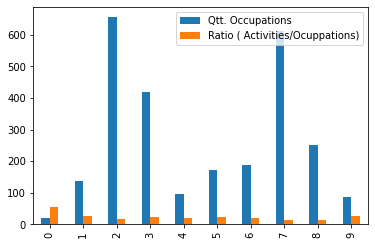

In [8]:
ax = data[['Group','Qtt. Occupations','Ratio ( Activities/Ocuppations)']].plot.bar()


fig = ax.get_figure()
fig.savefig('images/qtt_occupation_ratio_activities')

## Data Cleaning

The only columns used in this work will be **CBO Code** and **Activity**.

In [9]:
occupational_profile = occupational_profile[['CBO Code','Activity']]
occupational_profile.head(3)

,CBO Code,Activity
0,020105,Desenvolver atividades de polícia ostensiva
1,020105,Realizar estudos de situação
2,020105,Coordenar atividades de inteligência


Each legitimate __CBO Code__ are related to multiple __Activity__. The opposite is also true.

In [10]:
occupational_profile.groupby('CBO Code')['Activity'].count()

CBO Code
020105    127
020110    100
020115    100
020205    117
020305    123
         ... 
992205     38
992210     52
992215     30
992220     39
992225    103
Name: Activity, Length: 2641, dtype: int64

In [11]:
occupational_profile.groupby('Activity')['CBO Code'].count()

Activity
Abandonar a embarcação                                   1
Abastecer a descarnadeira com peles                      1
Abastecer a divisora com peles                           1
Abastecer a máquina com bobina, tinta etc.               4
Abastecer a máquina com cursores e fitas                 1
                                                        ..
Zelar pelos equipamentos, máquinas e acessórios          5
Zelar pelos pertences pessoais dos hóspedes e atores     5
Zelar por máquinas e equipamentos                       12
Zelar por uma postura ética na ação pedagógica          14
marketizar os imóveis                                    1
Name: CBO Code, Length: 45835, dtype: int64

## Map CBO to Integers

First we want to create a mapping of CBO codes to integers because the embedding neural network the number representation for proccessing. This mapping will let us keep track of the CBO codes. We'll also create the reverse mapping, from integers back to the CBO codes.

Converting directly the CBO code to integers would not be desirable as other brazilian databases related to employment uses the string representation of CBO code. Therefore it's important to maintain the original data for future use. 

In [22]:
cbo_index = {code : idx for idx,code in enumerate(occupational_profile['CBO Code'].unique())}
index_cbo = {idx : code for code,idx in cbo_index.items()}

cbo_index['141710']
index_cbo[113]

113

'141710'

In [23]:
unique_cbos = len(cbo_index)
print(f"There are {unique_cbos} CBO codes that have activities associated in CBO mapping.")


There are 2641 CBO codes that have activities associated in CBO mapping.


### Exploring Activities

Let's find the number of unique activities  and the most common ones. 

In [24]:

activities = list(occupational_profile['Activity'].unique())
print(f"There are {len(activities)} unique activities.")


There are 45835 unique activities.


### Most frequent activities

Let's take a look at which activities are most frequent related to by CBO codes. 

We'll make a utility function that takes in a list and returns a sorted ordered dictionary of the counts of the items in the list. The `collections` module has a number of useful functions for dealing with groups of objects.

In [25]:
from collections import Counter, OrderedDict

def count_items(l):
    """Return ordered dictionary of counts of objects in `l`"""
    
    # Create a counter object
    counts = Counter(l)
    
    # Sort by highest count first and place in ordered dictionary
    counts = sorted(counts.items(), key = lambda x: x[1], reverse = True)
    counts = OrderedDict(counts)
    
    return counts

In [26]:
non_unique_activities = list(occupational_profile['Activity'].values)


activities_counts = count_items(non_unique_activities)
list(activities_counts.items())[:10]

[('Trabalhar em equipe', 1385),
 ('Demonstrar criatividade', 771),
 ('Demonstrar iniciativa', 569),
 ('Demonstrar flexibilidade', 390),
 ('Elaborar relatórios', 319),
 ('Demonstrar dinamismo', 276),
 ('Demonstrar capacidade de liderança', 250),
 ('Tomar decisões', 245),
 ('Demonstrar capacidade de trabalhar em equipe', 238),
 ('Demonstrar capacidade de negociação', 236)]

The activity most related to CBO codes is 'Trabalhar em equipe' ('Team work' in english). It is expected in 52% of CBO's.

In [27]:
print(f"Team work is associated with {100*1385/ unique_cbos}%  of CBO's.")

Team work is associated with 52.442256720939035%  of CBO's.



#### Remove Most Popular Activities

I'm going to remove the __most popular__ activities because these are not very informative. So, activities related to more than 15% of CBO's will be removed.

(This step is similar to the idea of [TF-IDF (Term Frequency Inverse Document Frequency](http://www.tfidf.com/). When dealing with words in documents, the words that appear most often across documents are usually not that helpful because they don't distinguish documents. TF-IDF is a way to weight a word higher for appearing more often within an article but decrease the weighting for a word appearing more often between articles.)

In [28]:
[(i[0], i[1],i[1]/unique_cbos) for i in list(activities_counts.items())[:10]]

[('Trabalhar em equipe', 1385, 0.5244225672093904),
 ('Demonstrar criatividade', 771, 0.29193487315410827),
 ('Demonstrar iniciativa', 569, 0.21544869367663763),
 ('Demonstrar flexibilidade', 390, 0.1476713366149186),
 ('Elaborar relatórios', 319, 0.12078758046194624),
 ('Demonstrar dinamismo', 276, 0.10450586898901931),
 ('Demonstrar capacidade de liderança', 250, 0.09466111321469141),
 ('Tomar decisões', 245, 0.09276789095039757),
 ('Demonstrar capacidade de trabalhar em equipe', 238, 0.09011737978038621),
 ('Demonstrar capacidade de negociação', 236, 0.08936009087466869)]

In [29]:
to_remove = ['Trabalhar em equipe', 'Demonstrar criatividade', 'Demonstrar iniciativa']
for t in to_remove:
    non_unique_activities.remove(t)
    activities.remove(t)
    _ = activities_counts.pop(t)

Although there are so many unique activities, in thus study activities related with few CBO codes will not be removed as it can be a feature important to distinguish between different occupations.

In [30]:
valid_activities = [t[0] for t in activities_counts.items()] 
len(valid_activities)

45832

#### CBO codes associated with more activities

As a final bit of exploration, let's look at the CBO codes that are related to more activities than others. 

In [22]:
# Find set of activities for each cbo
non_unique_cbos = list(occupational_profile['CBO Code'].values)
cbo_counts = count_items(non_unique_cbos)
list(cbo_counts.items())[:10]

[('215125', 181),
 ('215115', 180),
 ('215140', 174),
 ('223305', 170),
 ('725605', 155),
 ('254105', 152),
 ('239220', 151),
 ('021205', 145),
 ('021210', 145),
 ('234510', 145)]

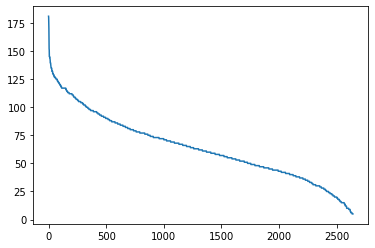

In [31]:
import matplotlib.pyplot as plt

plt.plot(range(len(cbo_counts)), cbo_counts.values())

plt.savefig('images/occupation_most_activities')

## Activities to Index

As with the CBO codes, we need to map the activities to integers. We'll also create the reverse mapping.

In [31]:
activity_index = {link: idx for idx, link in enumerate(activities)}
index_activity = {idx: link for link, idx in activity_index.items()}

activity_index['Demonstrar dinamismo']
index_activity[872]
print(f'There are {len(activity_index)} activities that will be used.')

872

'Demonstrar dinamismo'

There are 45832 activities that will be used.


# Supervised Machine Learning Task

Now that we have clean data, we'll move on to the second step: developing a supervised machine learning task to train an embedding neural network. As a reminder, we'll state the problem as: given a CBO code and a activity, identify if the activity is related to the CBO code.

## Build a Training Set

In order for any machine learning model to learn, it needs a training set. We are going to treat this as a supervised learning problem: given a pair (CBO code, activity), we want the neural network to learn to predict whether this is a legitimate pair - present in the data - or not.

To create a training set, for each CBO code, we'll iterate through the related activities and record the CBO code and each asctivity as a tuple. The final `pairs` list will consist of tuples of every (CBO code, activity) pairing on all Brazilian Occupational Profile.

In [33]:
pairs = []

#remove invalid activies
valid_occupational_profile =occupational_profile[occupational_profile['Activity'].isin(valid_activities)]

# Iterate through each row in occupational profile
for index, row in valid_occupational_profile.iterrows():
    pairs.append((cbo_index[row['CBO Code']], activity_index[row['Activity']]))
    
len(pairs), len(valid_activities), unique_cbos
pairs[200]

(167112, 45832, 2641)

(1, 102)

We now have over 160,000 positive examples on which to train! Each pair represents one activity for one CBO code. Let's look at a few examples.

In [34]:
index_cbo[pairs[5000][0]], index_activity[pairs[5000][1]]

('122605', 'Controlar a implementação das normas de qualidade')

Later on we'll create the negative examples by randomly sampling from the activities and the CBO codes and making sure the resulting pair is not in `pairs`. 

In [35]:
pairs_set = set(pairs)

Just for fun, let's look at the (cbo code, activity) pairs that are represented most often in the data. 

In [36]:
x = Counter(pairs)
sorted(x.items(), key = lambda x: x[1], reverse = True)[:5]

[((2246, 39384), 2),
 ((2247, 39384), 2),
 ((2248, 39384), 2),
 ((2249, 39384), 2),
 ((0, 0), 1)]

Given that occupations should not be linked to activities more than once, multiple links will be deleted in order to guarantee that rule. 

In [37]:
pairs = [key for key in x.keys()]

In [38]:
x = Counter(pairs)
sorted(x.items(), key = lambda x: x[1], reverse = True)[:5]

[((0, 0), 1), ((0, 1), 1), ((0, 2), 1), ((0, 3), 1), ((0, 4), 1)]

## Note about Training / Testing Set

To compute the embeddings, we are not going to create a separate validation or testing set. While this is a __must__ for a normal supervised machine learning task, in this case, our primary objective is not to make the most accurate model, but to generate the best embeddings. The prediction task is just the method through which we train our network to make the embeddings. At the end of training, we are not going to be testing our model on new data, so we don't need to evaluate the performance. Instead of testing on new data, we'll look at the embeddings themselves to see if CBO codes that we think are similar have embeddings that are close to each other. 

If we kept a separate validation / testing set, then we would be limiting the amount of data that our network can use to train. This would result in less accurate embeddings. Normally with any supervised model, we need to be concerned about overfitting, but again, because we do not need our model to generalize to new data and our goal is the embeddings, we will make our model as effective as possible by using all the data for training. In general, always have a separate validation and testing set (or use cross validation) and make sure to regularize your model to prevent overfitting. 

## Preparing data for comparison

Before the training,  it's important to define some criterion that allows to compare the resulting vector with the original data. In this sense it will be create a new table containing at each row two different CBO codes and the similarity between them measured by the number of equal activities.

In [39]:
table_comparison = pd.DataFrame(columns = ['cbo_idx','activity_idx'],data = pairs)
table_comparison = table_comparison.groupby('cbo_idx')['activity_idx'].apply(list).reset_index()
table_comparison.head()

,cbo_idx,activity_idx
0,0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
1,1,"[0, 1, 2, 4, 125, 5, 6, 7, 8, 9, 10, 11, 12, 1..."
2,2,"[0, 1, 2, 4, 125, 5, 6, 7, 8, 9, 10, 11, 12, 1..."
3,3,"[126, 127, 128, 129, 130, 131, 132, 133, 134, ..."
4,4,"[234, 235, 236, 237, 238, 239, 240, 241, 242, ..."


The funcion bellow will measure the similarity between CBO's based on the aforementioned rule

In [39]:
import math
def set_cosine_similarity(c1, c2):
    terms = set(c1).union(set(c2))
    dotprod = sum((1*(k in c1)) * (1*(k in c2)) for k in terms)
    magA = math.sqrt(sum((1*(k in c1))**2 for k in terms))
    magB = math.sqrt(sum((1*(k in c2)) **2 for k in terms))
    return dotprod / (magA * magB)


Construct a matrix NxN where N is the total number of CBO codes and each cell of the resulting matrix at row i and column j store the similarity between CBO codes of index i and j

In [40]:
from IPython.display import clear_output

def process_similarity(row):
    referencia = row.name #indice
    for i in row.index: #para cada cbo ( colunas )
        row[i] = set_cosine_similarity(table_comparison.loc[referencia]['activity_idx'],table_comparison.loc[i]['activity_idx'])

index = table_comparison['cbo_idx'].unique()

In [ ]:
df_matrix = pd.DataFrame(columns=index, index=index)
z=0

total = df_matrix.shape[0]
for i,r in df_matrix.iterrows():
    clear_output(wait=True)
    z+=1
    print(str(100*z/total)+'% concluído')
    process_similarity(r)

In [73]:
df_matrix.to_csv('../resources/similarity.csv')

In [41]:
df_matrix= pd.read_csv('../resources/similarity.csv').drop('Unnamed: 0',axis=1)

In [42]:
df_matrix.head()

,0,1,2,3,4,5,6,7,8,9,...,2631,2632,2633,2634,2635,2636,2637,2638,2639,2640
0,1.000000,0.876403,0.876403,0.074421,0.008098,0.008098,0.016754,0.016754,0.022439,0.022439,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.876403,1.000000,1.000000,0.084050,0.009145,0.009145,0.018922,0.018922,0.025342,0.025342,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.876403,1.000000,1.000000,0.084050,0.009145,0.009145,0.018922,0.018922,0.025342,0.025342,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.074421,0.084050,0.084050,1.000000,0.008370,0.008370,0.000000,0.000000,0.015462,0.015462,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.008098,0.009145,0.009145,0.008370,1.000000,1.000000,0.025438,0.025438,0.030284,0.030284,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In order to allow the direct comparison of two CBO codes, the matrix will be transformed in a Dataframe where the first two columns contains the index of the compared CBO's and the third column contais the similarity between them.

In [43]:
data_similarity = df_matrix.stack().reset_index(name='similarity').rename(columns={'level_1':'cbo_idx2','level_0':'cbo_idx1'})


In [44]:
data_similarity.head()

,cbo_idx1,cbo_idx2,similarity
0,0,0,1.000000
1,0,1,0.876403
2,0,2,0.876403
3,0,3,0.074421
4,0,4,0.008098


For the purpose of comparing average similarity of groups and major subgroups, it will created in the similarity matrix features related to this information for each cbo code compared. 

In [44]:


data_similarity['cbo1'] = [index_cbo[idx] for idx in data_similarity['cbo_idx1'].values]
data_similarity['cbo2'] = [index_cbo[int(idx)] for idx in data_similarity['cbo_idx2'].values]


data_similarity['cbo1_group'] = [index_cbo[idx][:1] for idx in data_similarity['cbo_idx1'].values]
data_similarity['cbo2_group'] = [index_cbo[int(idx)][:1] for idx in data_similarity['cbo_idx2'].values]

data_similarity['cbo1_major_subgroup'] = [index_cbo[idx][:2] for idx in data_similarity['cbo_idx1'].values]
data_similarity['cbo2_major_subgroup'] = [index_cbo[int(idx)][:2] for idx in data_similarity['cbo_idx2'].values]
data_similarity.head(10)

,cbo_idx1,cbo_idx2,similarity,cbo1,cbo2,cbo1_group,cbo2_group,cbo1_major_subgroup,cbo2_major_subgroup
0,0,0,1.000000,020105,020105,0,0,02,02
1,0,1,0.876403,020105,020110,0,0,02,02
2,0,2,0.876403,020105,020115,0,0,02,02
3,0,3,0.074421,020105,020205,0,0,02,02
4,0,4,0.008098,020105,020305,0,0,02,02
5,0,5,0.008098,020105,020310,0,0,02,02
6,0,6,0.016754,020105,021105,0,0,02,02
7,0,7,0.016754,020105,021110,0,0,02,02
8,0,8,0.022439,020105,021205,0,0,02,02
9,0,9,0.022439,020105,021210,0,0,02,02


The following plot shows that, in average, the similarity of CBO codes inside groups are higher than those from different groups.

<BarContainer object of 10 artists>

<BarContainer object of 10 artists>

Text(0.5, 1.0, 'Average similarity of CBO codes related to groups')

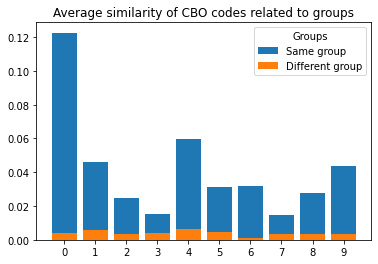

In [33]:

data_similarity_inside_group = data_similarity[data_similarity['cbo1_group']==data_similarity['cbo2_group']].groupby('cbo1_group')['similarity'].describe().reset_index()
data_similarity_outside_group = data_similarity[data_similarity['cbo1_group']!=data_similarity['cbo2_group']].groupby('cbo1_group')['similarity'].describe().reset_index()



plt.bar(data_similarity_inside_group['cbo1_group'],data_similarity_inside_group['mean'],label="Same group")
plt.bar(data_similarity_outside_group['cbo1_group'],data_similarity_outside_group['mean'],label="Different group")

plt.title("Average similarity of CBO codes related to groups")
plt.legend(title="Groups")
plt.savefig('images/average_similarity_groups')

plt.show()

#fig = plt.get_figure()
#fig = ax.get_figure()



However, it's important to observe that, in general, most of CBO codes have similiarity values lower than 0.1 even when compared to other codes in the same group, as observed in the following plot.

<AxesSubplot:xlabel='Group', ylabel='similarity'>

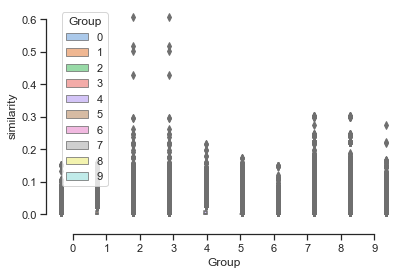

In [49]:
import seaborn as sns

sns.set_theme(style="ticks", palette="pastel")

sns.boxplot(x="Group", y="similarity",
            hue="Group", 
            data=data_similarity[data_similarity['cbo1_group']!=data_similarity['cbo2_group']].rename(columns = {'cbo1_group' : 'Group'}))
sns.despine(offset=10, trim=True)

plt.savefig('images/boxplot_bygroup')

From the analysis of the heat map, it is possible to confirm that most of CBO codes have lower similarity when compared to others.

<AxesSubplot:>

Text(0.5, 1.0, 'Heatmap of the similarity between CBO codes')

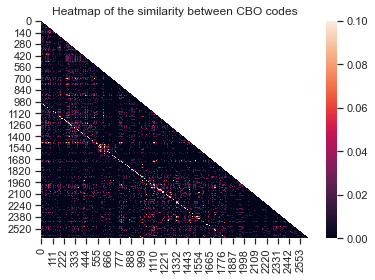

In [50]:
import numpy as np
data_mainsubgroups_similarity = data_similarity.reset_index().pivot(index='cbo_idx1',columns='cbo_idx2',values='similarity').to_numpy()

mask = np.zeros_like(data_mainsubgroups_similarity)
mask[np.triu_indices_from(mask)] = True

ax = plt.axes()

sns.heatmap(data_mainsubgroups_similarity,mask=mask, vmax=0.1,ax = ax)
ax.set_title('Heatmap of the similarity between CBO codes')

plt.savefig('images/heatmap')

plt.show()


## Generator For Training Samples

We need to generate positive samples and negative samples to train the neural network. The positive samples are simple: pick a pair from `pairs` and assign it a 1. The negative samples are also fairly easy: pick one random activity and one random CBO code, make sure they are not in `pairs`, and assign them a -1 or a 0. (We'll use either a -1 or 0 for the negative labels depending on whether we want to make this a regression or a classification problem. Either approach is valid, and we'll try out both methods.)

The code below creates a generator that yields batches of samples each time it is called. Neural networks are trained incrementally - a batch at a time - which means that a generator is a useful function for returning examples on which to train. Using a generator alleviates the need to store all of the training data in memory which might be an issue if we were working with a larger dataset such as images. 

In [91]:
import numpy as np
import random
random.seed(100)

def generate_batch(pairs, n_positive = 50, negative_ratio = 1.0, classification = False):
    """Generate batches of samples for training"""
    batch_size = n_positive * (1 + negative_ratio)
    batch = np.zeros((batch_size, 3))
    
    # Adjust label based on task
    if classification:
        neg_label = 0
    else:
        neg_label = -1
    
    # This creates a generator
    while True:
        # randomly choose positive examples
        for idx, (cbo_id, activity_id) in enumerate(random.sample(pairs, n_positive)):
            batch[idx, :] = (cbo_id, activity_id, 1)

        # Increment idx by 1
        idx += 1
        
        # Add negative examples until reach batch size
        while idx < batch_size:
            
            # random selection
            random_cbo = random.randrange(unique_cbos)
            random_activity = random.randrange(len(valid_activities))
            
            # Check to make sure this is not a positive example
            if (random_cbo, random_activity) not in pairs_set:
                
                # Add to batch and increment index
                batch[idx, :] = (random_cbo, random_activity, neg_label)
                idx += 1
                
        # Make sure to shuffle order
        np.random.shuffle(batch)
        yield {'cbo_code': batch[:, 0], 'activity': batch[:, 1]}, batch[:, 2]

To get a new batch, call `next` on the generator. 

In [52]:
next(generate_batch(pairs, n_positive = 2, negative_ratio = 2))

({'cbo_code': array([ 478., 1775., 1863., 1695.,  450., 1609.]),
  'activity': array([ 8496., 33217., 11452., 32569., 34924., 22920.])},
 array([ 1., -1., -1.,  1., -1., -1.]))

In [53]:
x, y = next(generate_batch(pairs, n_positive = 2, negative_ratio = 2))

# Show a few example training pairs
for label, b_idx, l_idx in zip(y, x['cbo_code'], x['activity']):
    print(f'CBO Code: {index_cbo[b_idx]:30} Activity: {index_activity[l_idx]:40} Label: {label}') 

CBO Code: 214430                         Activity: Especificar limites de referência (premissas) Label: 1.0
CBO Code: 311715                         Activity: Auxiliar no descarte de documentos       Label: -1.0
CBO Code: 224105                         Activity: Desenvolver treinamento com dados das avaliações realizadas Label: 1.0
CBO Code: 319105                         Activity: Capacidade sensorial                     Label: -1.0
CBO Code: 203520                         Activity: Desenformar para embalagem               Label: -1.0
CBO Code: 723310                         Activity: Estimar a quantidade de recursos humanos e materiais Label: -1.0


The neural network will take in the CBO code index and the activity index and try to embed them in such a way that it can predict the label from the embeddings.

# Neural Network Embedding Model

With our dataset and a supervised machine learning task, we're almost there. The next step is the most technically complicated but thankfully fairly simple with Keras. We are going to construct the neural network that learns the entity embeddings. The input to this network is the (CBO code, activity) (either positive or negative) as integers, and the output will be a prediction of whether or not the activity is related to a CBO code. However, we're not actually interested in the prediction except as the device used to train the network by comparison to the label. What we are after is at the heart of the network: the embedding layers, one for the CBO code and one for the activity each of which maps the input entity to a 50 dimensional vector. The layers of our network are as follows:

1. Input: parallel inputs for the cbo and activity
2. Embedding: parallel embeddings for the cbo and activity
3. Dot: computes the dot product between the embeddings to merge them together
4. Reshape: utility layer needed to correct the shape of the dot product
5. [Optional] Dense: fully connected layer with sigmoid activation to generate output for classification

After converting the inputs to an embedding, we need a way to combine the embeddings into a single number. For this we can use the dot product which does element-wise multiplication of numbers in the vectors and then sums the result to a single number. This raw number (after reshaping) is then the ouput of the model for the case of regression. In regression, our labels are either -1 or 1, and so the model loss function will be mean squared error in order to minimize the distance between the prediction and the output. Using the dot product with normalization means that the `Dot` layer is finding the cosine similarity between the embedding for the CBO code and the activity. Using this method for combining the embeddings means we are trying to make the network learn similar embeddings for cbo codes that link to similar activities. 

### Classification vs Regression

For classification, we add an extra fully connected `Dense` layer with a `sigmoid` activation to squash the outputs between 0 and 1 because the labels are either 0 or 1. The loss function for classification is `binary_crossentropy` which measures the [error of the neural network predictions in a binary classification problem](https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html), and is a measure of the similarity between two distributions. We can train with either classification or regression, and in practice, I found that both approaches produced similar embeddings. I'm not sure about the technical merits of these methods, and I'd be interested to hear if one is better than the other. 

The optimizer - the algorithm used to update the parameters (also called weights) of the neural network after calculating the gradients through backpropagation - is Adam in both cases ([Adam is a modification to Stochastic Gradient Descent](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/)). We use the default parameters for this optimizer. The nice thing about modern neural network frameworks is we don't have to worry about backpropagation or updating the model parameters because that is done for us. It's nice to have an idea of what is occuring behind the scenes, but it's not entirely necessary to use a neural network effectively. 

In [93]:
from keras.layers import Input, Embedding, Dot, Reshape, Dense
from keras.models import Model

In [94]:
def cbo_embedding_model(embedding_size = 50, classification = False):
    """Model to embed cbo codes and acitivities using the functional API.
       Trained to discern if a activity is linked to a CBO code"""
    
    # Both inputs are 1-dimensional
    cbo_code = Input(name = 'cbo_code', shape = [1])
    activity = Input(name = 'activity', shape = [1])
    
    # Embedding the CBO (shape will be (None, 1, 50))
    cbo_embedding = Embedding(name = 'cbo_embedding',
                               input_dim = len(cbo_index),
                               output_dim = embedding_size)(cbo_code)
    
    # Embedding the ACtivity (shape will be (None, 1, 50))
    activity_embedding = Embedding(name = 'activity_embedding',
                               input_dim = len(activity_index),
                               output_dim = embedding_size)(activity)
    
    # Merge the layers with a dot product along the second axis (shape will be (None, 1, 1))
    merged = Dot(name = 'dot_product', normalize = True, axes = 2)([cbo_embedding, activity_embedding])
    
    # Reshape to be a single number (shape will be (None, 1))
    merged = Reshape(target_shape = [1])(merged)
    
    # If classifcation, add extra layer and loss function is binary cross entropy
    if classification:
        merged = Dense(1, activation = 'sigmoid')(merged)
        model = Model(inputs = [cbo_code, activity], outputs = merged)
        model.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    # Otherwise loss function is mean squared error
    else:
        model = Model(inputs = [cbo_code, activity], outputs = merged)
        model.compile(optimizer = 'Adam', loss = 'mse')
    
    return model

# Instantiate model and show parameters
model = cbo_embedding_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
cbo_code (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
activity (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
cbo_embedding (Embedding)       (None, 1, 50)        132050      cbo_code[0][0]                   
__________________________________________________________________________________________________
activity_embedding (Embedding)  (None, 1, 50)        2291600     activity[0][0]                   
______________________________________________________________________________________________

There are nearly 2.5 million weights (parameters) that need to be learned by the neural network. Each of these represents one number in an embedding for one entity. During training, the neural network adjusts these parameters in order to minimize the loss function on the training data. 

# Train Model

We have the training data - in a generator - and a model. The next step is to train the model to learn the entity embeddings. During this process, the model will update the embeddings (change the model parameters) to accomplish the task of predicting whether a certain activity is related a cbo code. The resulting embeddings can then be used as a representation of cbo codes and activities. 

There are a few parameters to adjust for training. The batch size should generally be as large as possible given the memory constraints of your machine. The negative ratio can be adjusted based on results. I tried 2 and it seemed to work well. The number of steps per epoch is chosen such that the model sees a number of examples equal to the number of pairs on each epoch. This is repeated for 15 epochs (which might be more than necessary).

In [289]:
n_positive = 1024

gen = generate_batch(pairs, n_positive, negative_ratio = 2)

# Train
h = model.fit_generator(gen, epochs = 25, 
                        steps_per_epoch = len(pairs) // n_positive,
                        verbose = 1)

c:\users\amilt\appdata\local\programs\python\python39\lib\site-packages\keras\engine\training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/25
163/163 [==============================] - 4s 24ms/step - loss: 0.3871
Epoch 2/25
163/163 [==============================] - 4s 27ms/step - loss: 0.3866
Epoch 3/25
163/163 [==============================] - 4s 25ms/step - loss: 0.3859
Epoch 4/25
163/163 [==============================] - 4s 27ms/step - loss: 0.3858
Epoch 5/25
163/163 [==============================] - 4s 25ms/step - loss: 0.3862
Epoch 6/25
163/163 [==============================] - 4s 25ms/step - loss: 0.3848
Epoch 7/25
163/163 [==============================] - 4s 26ms/step - loss: 0.3851
Epoch 8/25
163/163 [==============================] - 5s 32ms/step - loss: 0.3849
Epoch 9/25
163/163 [==============================] - 5s 34ms/step - loss: 0.3848
Epoch 10/25
163/163 [==============================] - 5s 29ms/step - loss: 0.3847
Epoch 11/25
163/163 [==============================] - 6s 34ms/step - loss: 0.3847
Epoch 12/25
163/163 [==============================] - 6s 35ms/step - loss: 0.3844
Epoch 13/25
1

The loss decreases as training progresses which should give us confidence the model is learning something! 


The entire trained model can be saved and later loaded in so you don't have to repeat the training. It's also possible to save certain layers.

In [290]:
model.save('../models/cbo_attempt_reg_batch1024.h5')

In [1]:
import keras
model = keras.models.load_model('../models/cbo_attempt_reg_batch256.h5')

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


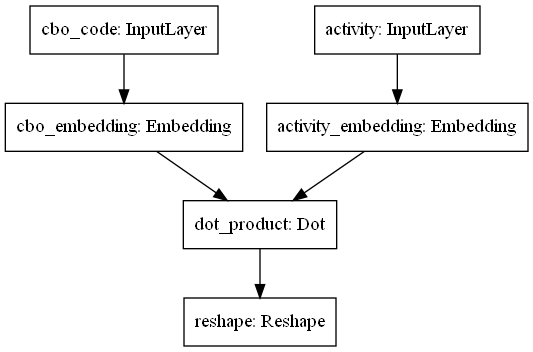

In [59]:
from tensorflow.keras.utils import plot_model

plot_model(
    model, to_file='./images/model.png', show_shapes=False, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

# Extract Embeddings and Analyze

The trained model has learned - hopefully - representations of CBO codes and activities that place similar entities next to one another in the embedding space. 

In [2]:
# Extract embeddings
cbo_layer = model.get_layer('cbo_embedding')
cbo_weights = cbo_layer.get_weights()[0]
cbo_weights.shape

(2641, 50)

Each cbo code is now represented as a 50-dimensional vector. 

We need to normalize the embeddings so that the dot product between two embeddings becomes the cosine similarity.

In [4]:
import numpy as np
cbo_weights = cbo_weights / np.linalg.norm(cbo_weights, axis = 1).reshape((-1, 1))
cbo_weights[0][:10]
np.sum(np.square(cbo_weights[0]))

1.0000001

Normalize just means divide each vector by the square root of the sum of squared components.

# Finding Similar CBO codes

After We've trained the model and extracted the embeddings It's necessary to evaluate how good the vector representation is.



### Function to Find Most Similar Entities

The function below takes in either a cbo code or a activity, a set of embeddings, and returns the `n` most similar items to the query. It does this by computing the dot product between the query and embeddings. Because we normalized the embeddings, the dot product represents the [cosine similarity](http://blog.christianperone.com/2013/09/machine-learning-cosine-similarity-for-vector-space-models-part-iii/) between two vectors. 

Once we have the dot products, we have the distance between any two vectors in the embedding space. With cosine similarity, higher numbers indicate entities that are closer together, with -1 the furthest apart and +1 closest together.

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 15

def get_distance_matrix(weights,idx):
    """Find n most similar items (or least) to name based on embeddings. Option to also plot the results"""
    
    # Check to make sure `name` is in index
    try:
        # Calculate dot product between all cbo codes
        data_matrix_vec = []
        for i in idx :
            dists = np.dot(weights, weights[i])
            data_matrix_vec.append(dists)
    except KeyError:
        print(f'{name} Not Found.')
        return
    
    return data_matrix_vec     
    

In [119]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 15

def find_similar(name, weights, index_name = 'cbo', n = 10, least = False, return_dist = False, plot = False):
    """Find n most similar items (or least) to name based on embeddings. Option to also plot the results"""
    
    # Select index and reverse index
    if index_name == 'cbo':
        idx = cbo_index
        rindex = index_cbo
    elif index_name == 'activity':
        idx = activity_index
        rindex = index_activity
    
    # Check to make sure `name` is in index
    try:
        # Calculate dot product between cbo codes and all others
        dists = np.dot(weights, weights[idx[name]])
    except KeyError:
        print(f'{name} Not Found.')
        return
    
    # Sort distance indexes from smallest to largest
    sorted_dists = np.argsort(dists)

  
    # Plot results if specified
    if plot:
        
        # Find furthest and closest items
        furthest = sorted_dists[:(n // 2)]
        closest = sorted_dists[-n-1: len(dists) - 1]
        items = [rindex[c] for c in furthest]
        items.extend(rindex[c] for c in closest)
        
        # Find furthest and closets distances
        distances = [dists[c] for c in furthest]
        distances.extend(dists[c] for c in closest)
        
        colors = ['r' for _ in range(n //2)]
        colors.extend('g' for _ in range(n))
        
        data = pd.DataFrame({'distance': distances}, index = items)
        
        # Horizontal bar chart
        data['distance'].plot.barh(color = colors, figsize = (10, 8),
                                   edgecolor = 'k', linewidth = 2)
        plt.xlabel('Cosine Similarity');
        plt.axvline(x = 0, color = 'k');
        
        # Formatting for italicized title
        name_str = f'{index_name.capitalize()}s Most and Least Similar to'
        for word in name.split():
            # Title uses latex for italize
            name_str += ' $\it{' + word + '}$'
        plt.title(name_str, x = 0.2, size = 28, y = 1.05)
        
        return None
    
    # If specified, find the least similar
    if least:
        # Take the first n from sorted distances
        closest = sorted_dists[:n]
         
        print(f'{index_name.capitalize()}s furthest from {name}.\n')
        
    # Otherwise find the most similar
    else:
        # Take the last n sorted distances
        closest = sorted_dists[-n:]
        
        # Need distances later on
        if return_dist:
            return dists, closest
        
        
        print(f'{index_name.capitalize()}s closest to {name}.\n')
        
    # Need distances later on
    if return_dist:
        return dists, closest
    
    
    # Print formatting
    max_width = max([len(rindex[c]) for c in closest])
    
    # Print the most similar and distances
    for c in reversed(closest):
        print(f'{index_name.capitalize()}: {rindex[c]:{max_width + 2}} Similarity: {dists[c]:.{2}}')
        
    

In [293]:
find_similar('214215', cbo_weights, n =5,plot=False)

Cbos closest to 214215.

Cbo: 214215   Similarity: 1.0
Cbo: 214230   Similarity: 1.0
Cbo: 214220   Similarity: 1.0
Cbo: 214245   Similarity: 1.0
Cbo: 214255   Similarity: 1.0


## Model evaluation - regression strategy

From the error distance,we it's now necessary to evaluate the model's quality

In [46]:
data_matrix_vec = get_distance_matrix(cbo_weights,index)
df_matrix_vec = pd.DataFrame(columns=index, index=index,data = data_matrix_vec)
df_matrix_vec.head()

,0,1,2,3,4,5,6,7,8,9,...,2631,2632,2633,2634,2635,2636,2637,2638,2639,2640
0,1.000000,0.978726,0.981993,0.408231,0.172464,0.119781,0.257770,0.242331,0.195146,0.169933,...,0.245663,0.203584,0.317629,-0.068249,0.257188,0.372769,0.279763,0.372777,0.315439,0.150545
1,0.978726,1.000000,0.980616,0.404192,0.176151,0.124251,0.319786,0.294639,0.221099,0.187848,...,0.323147,0.250002,0.374671,-0.054972,0.308891,0.428780,0.322107,0.443944,0.363968,0.170635
2,0.981993,0.980616,1.000000,0.413847,0.188395,0.147691,0.320438,0.301038,0.254700,0.237093,...,0.238166,0.190780,0.304992,-0.067626,0.244625,0.366206,0.276121,0.374985,0.315183,0.148575
3,0.408231,0.404192,0.413847,1.000000,-0.116055,-0.118018,-0.032057,0.009817,-0.063814,-0.053394,...,-0.111792,-0.016805,0.061659,-0.043204,0.009770,0.089808,0.121674,0.094830,0.150443,0.140650
4,0.172464,0.176151,0.188395,-0.116055,1.000000,0.973546,0.216298,0.229872,0.297660,0.270462,...,0.205010,0.173557,0.241715,-0.019205,0.195655,0.229740,0.188387,0.244908,0.215577,0.133990


In [47]:
data_similarity_vec = df_matrix_vec.stack().reset_index(name='similarity').rename(columns={'level_1':'cbo_idx2','level_0':'cbo_idx1'})
data_similarity_vec = data_similarity_vec.rename(columns = {'similarity' : 'similarity_vec_reg'})
data_similarity_vec.head()

,cbo_idx1,cbo_idx2,similarity_vec_reg
0,0,0,1.000000
1,0,1,0.978726
2,0,2,0.981993
3,0,3,0.408231
4,0,4,0.172464


In [48]:
data_similarity['cbo_idx1'] = data_similarity['cbo_idx1'].astype(int)
data_similarity['cbo_idx2'] = data_similarity['cbo_idx2'].astype(int)
data_similarity_vec['cbo_idx1'] = data_similarity_vec['cbo_idx1'].astype(int)
data_similarity_vec['cbo_idx2'] = data_similarity_vec['cbo_idx2'].astype(int)

data_similarity_comparison = data_similarity.merge(data_similarity_vec,on=['cbo_idx1','cbo_idx2'],how='inner')

In [49]:
sim_mean=data_similarity_comparison['similarity_vec_reg'].mean()
sim_max=data_similarity_comparison['similarity_vec_reg'].max()
sim_min=data_similarity_comparison['similarity_vec_reg'].min()

data_similarity_comparison['norm_reg'] = data_similarity_comparison['similarity_vec_reg'].apply(lambda x: (x - sim_min) / (sim_max - sim_min))

In [50]:

data_similarity_comparison.head()

,cbo_idx1,cbo_idx2,similarity,cbo1,cbo2,cbo1_group,cbo2_group,cbo1_major_subgroup,cbo2_major_subgroup,similarity_vec_reg,norm_reg
0,0,0,1.000000,020105,020105,0,0,02,02,1.000000,1.000000
1,0,1,0.876403,020105,020110,0,0,02,02,0.978726,0.985081
2,0,2,0.876403,020105,020115,0,0,02,02,0.981993,0.987372
3,0,3,0.074421,020105,020205,0,0,02,02,0.408231,0.585007
4,0,4,0.008098,020105,020305,0,0,02,02,0.172464,0.419669


Evaluate the correlation between normalized similarity of vector representation and similarity of original representation using intersection of equal activites.

<AxesSubplot:xlabel='similarity', ylabel='norm_reg'>

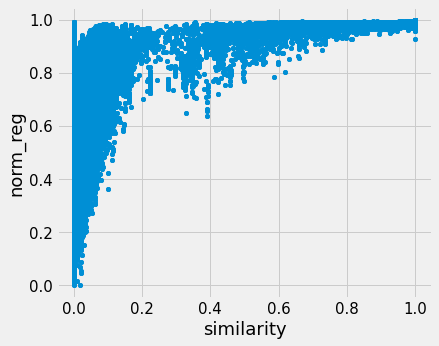

In [53]:
data_similarity_comparison.plot.scatter('similarity','norm_reg')

#sns.scatterplot(data=data_similarity_comparison, x="data_similarity_vec", y="data_similarity_vec")


In [56]:
data_similarity_comparison['error_reg'] = round(data_similarity_comparison['similarity'] - data_similarity_comparison['norm_reg'],3)


<AxesSubplot:>

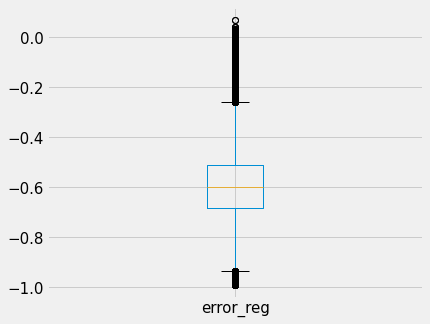

In [57]:

data_similarity_comparison.boxplot('error_reg')

## Extracting weights

In [8]:
def extract_weights(name, model):
    """Extract weights from a neural network model"""
    
    # Extract weights
    weight_layer = model.get_layer(name)
    weights = weight_layer.get_weights()[0]
    
    # Normalize
    weights = weights / np.linalg.norm(weights, axis = 1).reshape((-1, 1))
    return weights

## Classification Model

In order to evaluate if training for the mean squared error as a regression problem was the ideal approach, the classification model were also used. For this model, the negative examples receive a label of 0 and the loss function is binary cross entropy. The procedure for the neural network to learn the embeddings is exactly the same, only it will be optimizing for a slightly different measure.

In [224]:
model_class = cbo_embedding_model(50, classification = True)
gen = generate_batch(pairs, n_positive, negative_ratio=2, classification = True)

In [225]:
# Train the model to learn embeddings
h = model_class.fit_generator(gen, epochs = 15, steps_per_epoch= len(pairs) // n_positive,
                            verbose = 0)

c:\users\amilt\appdata\local\programs\python\python39\lib\site-packages\keras\engine\training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


In [ ]:
model_class.save('../models/cbo_attempt_class.h5')

In [122]:
model = keras.models.load_model('../models/cbo_attempt_class.h5')


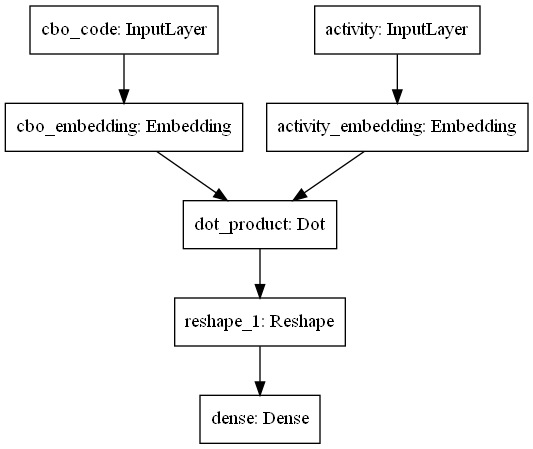

In [167]:
plot_model(
    model, to_file='./images/model.png', show_shapes=False, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

In [150]:
cbo_weights_class = extract_weights('cbo_embedding', model)
cbo_weights_class.shape

(2641, 50)

In [148]:
#data_similarity_comparison = data_similarity_comparison.drop(['similarity_vec_class_x','similarity_vec_class_y'],axis=1)
data_similarity_comparison = data_similarity_comparison.drop(['similarity_vec_class'],axis=1)

data_similarity_comparison.head()

,cbo_idx1,cbo_idx2,similarity,cbo1,cbo2,cbo1_group,cbo2_group,cbo1_major_subgroup,cbo2_major_subgroup,similarity_vec_reg,norm_reg,error_reg,norm_class,error_class,n_act_cbo1,n_act_cbo2,diff_n_act
0,0,0,1.000000,020105,020105,0,0,02,02,1.000000,1.000000,0.000,1.000000,0.000,125,125,0
1,0,1,0.876403,020105,020110,0,0,02,02,0.978726,0.985081,-0.109,0.984382,-0.108,125,98,27
2,0,2,0.876403,020105,020115,0,0,02,02,0.981993,0.987372,-0.111,0.987676,-0.111,125,98,27
3,0,3,0.074421,020105,020205,0,0,02,02,0.408231,0.585007,-0.511,0.528768,-0.454,125,117,8
4,0,4,0.008098,020105,020305,0,0,02,02,0.172464,0.419669,-0.412,0.362895,-0.355,125,122,3


### Evaluating the performance of classification model

In [151]:
data_matrix_vec = get_distance_matrix(cbo_weights_class,index)
df_matrix_vec = pd.DataFrame(columns=index, index=index,data = data_matrix_vec)
df_matrix_vec.head()

,0,1,2,3,4,5,6,7,8,9,...,2631,2632,2633,2634,2635,2636,2637,2638,2639,2640
0,1.000000,0.975247,0.980468,0.253141,-0.009753,-0.032994,0.240152,0.258430,0.058216,0.027675,...,-0.045875,0.133043,0.214647,0.087762,0.066052,0.301381,0.267197,0.302275,0.280915,0.261694
1,0.975247,1.000000,0.991902,0.213292,-0.041625,-0.081027,0.206846,0.213151,0.009491,-0.018032,...,0.014234,0.153155,0.243088,0.044638,0.083876,0.343286,0.292831,0.369979,0.323373,0.254763
2,0.980468,0.991902,1.000000,0.219980,0.007596,-0.028868,0.222245,0.231091,0.029907,-0.004317,...,0.000714,0.145624,0.236446,0.053630,0.073608,0.343280,0.300826,0.365534,0.321446,0.267538
3,0.253141,0.213292,0.219980,1.000000,-0.089882,-0.085619,-0.181364,-0.140709,0.017042,-0.001372,...,-0.097388,-0.345543,-0.328734,-0.271162,-0.329840,0.099371,0.136987,0.096496,0.105644,0.215399
4,-0.009753,-0.041625,0.007596,-0.089882,1.000000,0.983320,0.248997,0.293237,0.400940,0.383157,...,-0.195039,-0.082863,-0.112280,-0.002074,-0.039622,-0.055556,-0.025004,-0.032505,-0.007388,-0.004107


In [152]:
data_similarity_vec = df_matrix_vec.stack().reset_index(name='similarity').rename(columns={'level_1':'cbo_idx2','level_0':'cbo_idx1'})
data_similarity_vec = data_similarity_vec.rename(columns = {'similarity' : 'similarity_vec_class'})
#data_similarity_vec.head()


data_similarity_comparison = data_similarity_comparison.merge(data_similarity_vec,on=['cbo_idx1','cbo_idx2'],how='inner')

data_similarity_comparison.head()

,cbo_idx1,cbo_idx2,similarity,cbo1,cbo2,cbo1_group,cbo2_group,cbo1_major_subgroup,cbo2_major_subgroup,similarity_vec_reg,norm_reg,error_reg,norm_class,error_class,n_act_cbo1,n_act_cbo2,diff_n_act,similarity_vec_class
0,0,0,1.000000,020105,020105,0,0,02,02,1.000000,1.000000,0.000,1.000000,0.000,125,125,0,1.000000
1,0,1,0.876403,020105,020110,0,0,02,02,0.978726,0.985081,-0.109,0.984382,-0.108,125,98,27,0.975247
2,0,2,0.876403,020105,020115,0,0,02,02,0.981993,0.987372,-0.111,0.987676,-0.111,125,98,27,0.980468
3,0,3,0.074421,020105,020205,0,0,02,02,0.408231,0.585007,-0.511,0.528768,-0.454,125,117,8,0.253141
4,0,4,0.008098,020105,020305,0,0,02,02,0.172464,0.419669,-0.412,0.362895,-0.355,125,122,3,-0.009753


In [153]:
sim_mean=data_similarity_comparison['similarity_vec_class'].mean()
sim_max=data_similarity_comparison['similarity_vec_class'].max()
sim_min=data_similarity_comparison['similarity_vec_class'].min()

data_similarity_comparison['norm_class'] = data_similarity_comparison['similarity_vec_class'].apply(lambda x: (x - sim_min) / (sim_max - sim_min))

In [154]:
data_similarity_comparison.head()

,cbo_idx1,cbo_idx2,similarity,cbo1,cbo2,cbo1_group,cbo2_group,cbo1_major_subgroup,cbo2_major_subgroup,similarity_vec_reg,norm_reg,error_reg,norm_class,error_class,n_act_cbo1,n_act_cbo2,diff_n_act,similarity_vec_class
0,0,0,1.000000,020105,020105,0,0,02,02,1.000000,1.000000,0.000,1.000000,0.000,125,125,0,1.000000
1,0,1,0.876403,020105,020110,0,0,02,02,0.978726,0.985081,-0.109,0.984382,-0.108,125,98,27,0.975247
2,0,2,0.876403,020105,020115,0,0,02,02,0.981993,0.987372,-0.111,0.987676,-0.111,125,98,27,0.980468
3,0,3,0.074421,020105,020205,0,0,02,02,0.408231,0.585007,-0.511,0.528768,-0.454,125,117,8,0.253141
4,0,4,0.008098,020105,020305,0,0,02,02,0.172464,0.419669,-0.412,0.362895,-0.355,125,122,3,-0.009753


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='similarity', ylabel='norm_reg'>

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='similarity', ylabel='norm_class'>

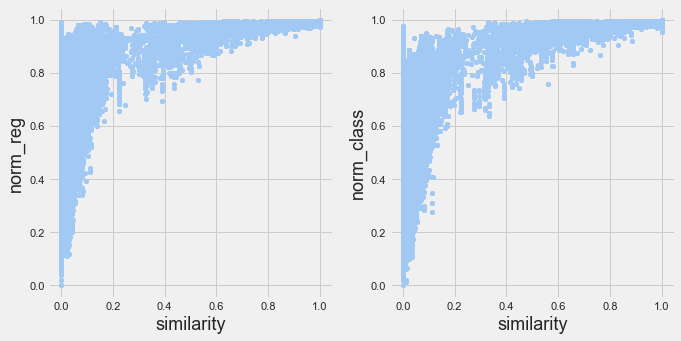

In [196]:
fig, axes = plt.subplots(nrows=1, ncols=2)
plt.rcParams["figure.figsize"] = (15, 5)

data_similarity_comparison.plot.scatter('similarity','norm_reg',ax=axes[0])
data_similarity_comparison.plot.scatter('similarity','norm_class',ax=axes[1])


In [155]:
data_similarity_comparison['error_class'] = round(data_similarity_comparison['similarity'] - data_similarity_comparison['norm_class'],3)

{'whiskers': [<matplotlib.lines.Line2D at 0x2112479aa30>,
 'caps': [<matplotlib.lines.Line2D at 0x210bf53f190>,
 'boxes': [<matplotlib.lines.Line2D at 0x2112479a6a0>,
 'medians': [<matplotlib.lines.Line2D at 0x210bf53f8b0>,
 'fliers': [<matplotlib.lines.Line2D at 0x210bf53fc40>,
 'means': []}

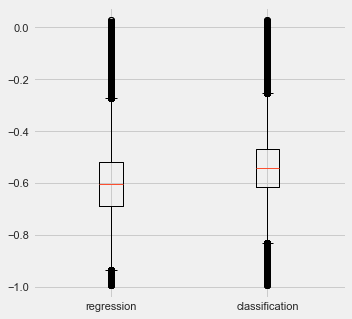

In [223]:
plt.rcParams["figure.figsize"] = (5, 5)
plt.boxplot ([data_similarity_comparison['error_reg'], data_similarity_comparison['error_class']], labels = ['regression','classification'])
plt.show()

In [173]:
data_similarity_comparison.sort_values('error_class',ascending=False).tail(15)

,cbo_idx1,cbo_idx2,similarity,cbo1,cbo2,cbo1_group,cbo2_group,cbo1_major_subgroup,cbo2_major_subgroup,similarity_vec_reg,norm_reg,error_reg,norm_class,error_class,n_act_cbo1,n_act_cbo2,diff_n_act,similarity_vec_class
5096545,1929,2056,0.0,731110,761366,7,7,73,76,0.972572,0.980765,-0.981,0.971488,-0.971,5,9,4,0.954812
4388748,1661,2047,0.0,632355,761339,6,7,63,76,0.963451,0.974369,-0.974,0.970616,-0.971,5,9,4,0.953429
5096541,1929,2052,0.0,731110,761354,7,7,73,76,0.971500,0.980013,-0.980,0.971180,-0.971,5,9,4,0.954323
5421261,2052,1929,0.0,761354,731110,7,7,76,73,0.971500,0.980013,-0.980,0.971180,-0.971,9,5,4,0.954323
5421265,2052,1933,0.0,761354,731130,7,7,76,73,0.980043,0.986004,-0.986,0.971267,-0.971,9,5,4,0.954461
4380711,1658,1933,0.0,632340,731130,6,7,63,73,0.986895,0.990810,-0.991,0.972517,-0.973,5,5,0,0.956442
5421271,2052,1939,0.0,761354,731160,7,7,76,73,0.969837,0.978847,-0.979,0.973151,-0.973,9,5,4,0.957448
5122951,1939,2052,0.0,731160,761354,7,7,73,76,0.969837,0.978847,-0.979,0.973151,-0.973,5,9,4,0.957448
5106711,1933,1658,0.0,731130,632340,7,6,73,63,0.986895,0.990810,-0.991,0.972517,-0.973,5,5,0,0.956442
5107109,1933,2056,0.0,731130,761366,7,7,73,76,0.981767,0.987214,-0.987,0.974878,-0.975,5,9,4,0.960184


In [174]:
np.dot(cbo_weights_class[1658],cbo_weights_class[1941])

0.9625787

## Analyzing errors  

In [78]:
cbo_qnt_act = { i : len(table_comparison.loc[i]['activity_idx']) for i in data_similarity_comparison['cbo_idx1'].unique()}

data_similarity_comparison_erros = data_similarity_comparison

data_similarity_comparison_erros['n_act_cbo1'] = [ cbo_qnt_act[i] for i in data_similarity_comparison['cbo_idx1'].values]
data_similarity_comparison_erros['n_act_cbo2'] = [ cbo_qnt_act[i] for i in data_similarity_comparison['cbo_idx2'].values]



In [81]:
data_similarity_comparison_erros['diff_n_act'] = abs(data_similarity_comparison_erros['n_act_cbo1'] - data_similarity_comparison_erros['n_act_cbo2'])
data_similarity_comparison_erros['sum_n_act'] = abs(data_similarity_comparison_erros['n_act_cbo1'] - data_similarity_comparison_erros['n_act_cbo2'])


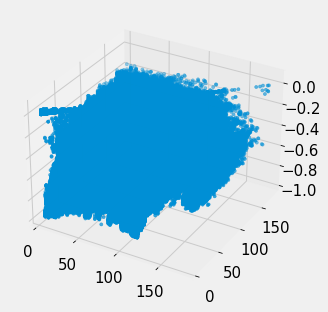

In [86]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax3D = fig.add_subplot(111, projection='3d')
ax3D.scatter(data_similarity_comparison_erros['n_act_cbo1'], data_similarity_comparison_erros['n_act_cbo2'], data_similarity_comparison_erros['error_class'], s=10, marker='o')

In [198]:
data_similarity_comparison_erros[data_similarity_comparison_erros['cbo1']!=data_similarity_comparison_erros['cbo2']]

,cbo_idx1,cbo_idx2,similarity,cbo1,cbo2,cbo1_group,cbo2_group,cbo1_major_subgroup,cbo2_major_subgroup,similarity_vec_reg,norm_reg,error_reg,similarity_vec_class,norm_class,error_class,n_act_cbo1,n_act_cbo2,diff_n_act
1,0,1,0.876403,020105,020110,0,0,02,02,0.978726,0.985081,-0.109,0.975247,0.984382,-0.108,125,98,27
2,0,2,0.876403,020105,020115,0,0,02,02,0.981993,0.987372,-0.111,0.980468,0.987676,-0.111,125,98,27
3,0,3,0.074421,020105,020205,0,0,02,02,0.408231,0.585007,-0.511,0.253141,0.528768,-0.454,125,117,8
4,0,4,0.008098,020105,020305,0,0,02,02,0.172464,0.419669,-0.412,-0.009753,0.362895,-0.355,125,122,3
5,0,5,0.008098,020105,020310,0,0,02,02,0.119781,0.382724,-0.375,-0.032994,0.348231,-0.340,125,122,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6974875,2640,2635,0.016502,992225,992120,9,9,99,99,0.227931,0.458567,-0.442,0.162687,0.471696,-0.455,102,36,66
6974876,2640,2636,0.358114,992225,992205,9,9,99,99,0.833322,0.883113,-0.525,0.823753,0.888796,-0.531,102,37,65
6974877,2640,2637,0.499134,992225,992210,9,9,99,99,0.932548,0.952697,-0.454,0.911689,0.944280,-0.445,102,51,51
6974878,2640,2638,0.533211,992225,992215,9,9,99,99,0.770412,0.838995,-0.306,0.817320,0.884738,-0.352,102,29,73


<AxesSubplot:xlabel='Activities related to reference code', ylabel='Activities related to compared code'>

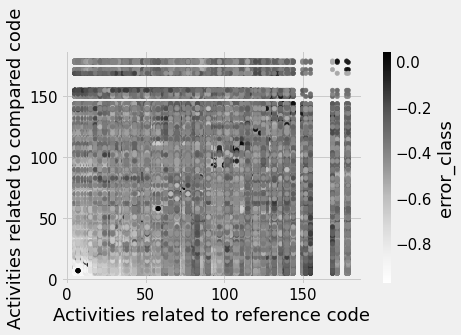

In [203]:
data_similarity_comparison_erros[data_similarity_comparison_erros['cbo1']!=data_similarity_comparison_erros['cbo2']].plot.scatter(x='n_act_cbo1',y='n_act_cbo2',c='error_class',xlabel='Activities related to reference code',ylabel ="Activities related to compared code")

In [175]:
table_comparison.loc[1658]['activity_idx']
table_comparison.loc[1941]['activity_idx']


[32107, 32108, 32109, 32110, 32111]

[7755, 35538, 35539, 8093, 15200]

In [176]:
np.dot(cbo_weights_class[1658],cbo_weights_class[1941])

0.9625787

In [160]:
activity_weights_class = extract_weights('activity_embedding', model)
activity_weights_class.shape



(45832, 50)

In [178]:
np.dot(activity_weights_class[[32107, 32108, 32109, 32110, 32111]], activity_weights_class[[7755, 35538, 35539, 8093, 15200]].T).max()

0.66322505

In [167]:
index_cbo[2056]
index_cbo[1933]


'761366'

'731130'

In [164]:
find_similar('761366', cbo_weights_class, n =10,plot=False)
find_similar('731130', cbo_weights_class, n =10,plot=False)

Cbos closest to 761366.

Cbo: 761366   Similarity: 1.0
Cbo: 761345   Similarity: 0.98
Cbo: 761339   Similarity: 0.97
Cbo: 761354   Similarity: 0.97
Cbo: 761318   Similarity: 0.97
Cbo: 761306   Similarity: 0.97
Cbo: 761336   Similarity: 0.97
Cbo: 761324   Similarity: 0.97
Cbo: 761342   Similarity: 0.97
Cbo: 761327   Similarity: 0.97
Cbos closest to 731130.

Cbo: 731130   Similarity: 1.0
Cbo: 731160   Similarity: 0.96
Cbo: 761366   Similarity: 0.96
Cbo: 731105   Similarity: 0.96
Cbo: 731110   Similarity: 0.96
Cbo: 632340   Similarity: 0.96
Cbo: 731170   Similarity: 0.96
Cbo: 731180   Similarity: 0.95
Cbo: 761354   Similarity: 0.95
Cbo: 632355   Similarity: 0.95


## Evaluate the representation with a lower number of dimensions

In [204]:
n_positive = 1024

model_class_8 = cbo_embedding_model(8, classification = True)
gen = generate_batch(pairs, n_positive, negative_ratio=2, classification = True)

In [205]:
# Train the model to learn embeddings
h = model_class_8.fit_generator(gen, epochs = 15, steps_per_epoch= len(pairs) // n_positive,
                            verbose = 0)

c:\users\amilt\appdata\local\programs\python\python39\lib\site-packages\keras\engine\training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


In [206]:
cbo_weights_class_8 = extract_weights('cbo_embedding', model_class_8)
cbo_weights_class_8.shape

(2641, 8)

In [210]:
data_matrix_vec = get_distance_matrix(cbo_weights_class_8,index)
df_matrix_vec = pd.DataFrame(columns=index, index=index,data = data_matrix_vec)

data_similarity_comparison_eval = data_similarity_comparison.drop(['similarity_vec_class'],axis=1)


data_similarity_vec = df_matrix_vec.stack().reset_index(name='similarity').rename(columns={'level_1':'cbo_idx2','level_0':'cbo_idx1'})
data_similarity_vec = data_similarity_vec.rename(columns = {'similarity' : 'similarity_vec_class_20'})


data_similarity_comparison_eval = data_similarity_comparison.merge(data_similarity_vec,on=['cbo_idx1','cbo_idx2'],how='inner')

sim_mean=data_similarity_comparison_eval['similarity_vec_class_20'].mean()
sim_max=data_similarity_comparison_eval['similarity_vec_class_20'].max()
sim_min=data_similarity_comparison_eval['similarity_vec_class_20'].min()

In [211]:
data_similarity_comparison_eval.head()

,cbo_idx1,cbo_idx2,similarity,cbo1,cbo2,cbo1_group,cbo2_group,cbo1_major_subgroup,cbo2_major_subgroup,similarity_vec_reg,norm_reg,error_reg,norm_class,error_class,n_act_cbo1,n_act_cbo2,diff_n_act,similarity_vec_class,similarity_vec_class_20
0,0,0,1.000000,020105,020105,0,0,02,02,1.000000,1.000000,0.000,1.000000,0.000,125,125,0,1.000000,1.000000
1,0,1,0.876403,020105,020110,0,0,02,02,0.978726,0.985081,-0.109,0.984382,-0.108,125,98,27,0.975247,0.989590
2,0,2,0.876403,020105,020115,0,0,02,02,0.981993,0.987372,-0.111,0.987676,-0.111,125,98,27,0.980468,0.988268
3,0,3,0.074421,020105,020205,0,0,02,02,0.408231,0.585007,-0.511,0.528768,-0.454,125,117,8,0.253141,0.040855
4,0,4,0.008098,020105,020305,0,0,02,02,0.172464,0.419669,-0.412,0.362895,-0.355,125,122,3,-0.009753,-0.147938


In [212]:
data_similarity_comparison_eval['norm_class'] = data_similarity_comparison_eval['similarity_vec_class_20'].apply(lambda x: (x - sim_min) / (sim_max - sim_min))

In [213]:
data_similarity_comparison_eval['error_class'] = round(data_similarity_comparison_eval['similarity'] - data_similarity_comparison_eval['norm_class'],3)

<AxesSubplot:xlabel='similarity', ylabel='norm_class'>

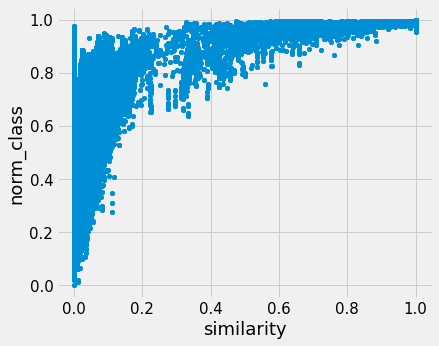

In [214]:
plt.rcParams["figure.figsize"] = (6, 5)

data_similarity_comparison.plot.scatter('similarity','norm_class')


# Visualizations

One of the most interesting parts about embeddings is that we can use them to visualize concepts such as _War and Peace_ or _biography_. First we have to take the embeddings from 50 dimensions down to either 3 or 2. We can do this using `pca`, `tsne`, or `umap`. We'll try both tsne and umap for comparison. TSNE takes much longer and is designed to retain local structure within the data. UMAP is generally quicker and is designed for a balance between local and global structure in the embedding.

## Manifold Embeddings

[TSNE: t-Stochastic Distributed Neighbors Embedding](https://lvdmaaten.github.io/tsne/) is a method that use the idea of a manifold to map vecotrs to a lower dimensional embedded space. Therefore, we are taking the 2,666 dimensions in the case of CBO codes, embedding them to 50 dimensions with the neural network, and then embedding them down to 2 dimensions with a manifold. The primary idea behind dimension reduction with a manifold is that there is a lower dimensional representation of the vectors that can still capture the variation between different groups. We want the embeddings to represent similar entities close to one another but in fewer dimensions that allow us to visualize the entities. 

In [263]:
from sklearn.manifold import TSNE
#from umap import UMAP

In [268]:
def reduce_dim(weights, components = 3, method = 'tsne'):
    """Reduce dimensions of embeddings"""
    if method == 'tsne':
        return TSNE(components, metric = 'cosine').fit_transform(weights)


In [269]:
cbo_r = reduce_dim(cbo_weights_class, components = 2, method = 'tsne')
cbo_r.shape

c:\users\amilt\appdata\local\programs\python\python39\lib\site-packages\sklearn\manifold\_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


(2641, 2)

We've now taken the initial 2,666 dimension CBO code vector and reduced it to just 2 dimensions.

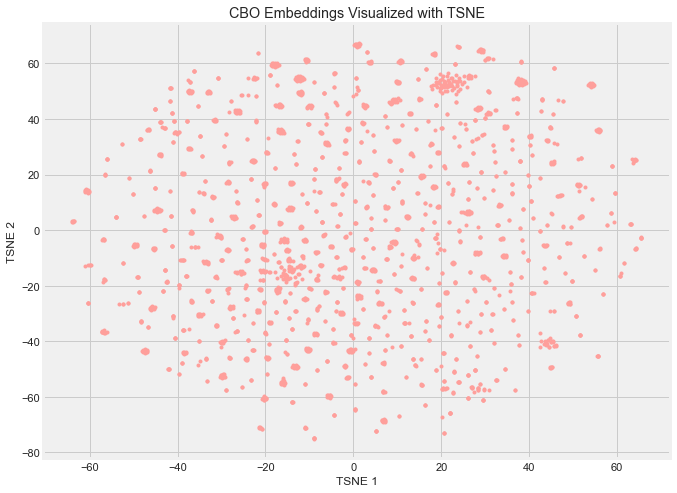

In [270]:
import matplotlib.pyplot as plt
%matplotlib inline

InteractiveShell.ast_node_interactivity = 'last'

plt.figure(figsize = (10, 8))
plt.plot(cbo_r[:, 0], cbo_r[:, 1], 'r.')
plt.xlabel('TSNE 1'); plt.ylabel('TSNE 2'); plt.title('CBO Embeddings Visualized with TSNE');

## CBO codes with higher similarity

In this section we will plot 15 CBO codes most similar to 214205 - Civil Engineer 

In [334]:

cbo_similar =  find_similar('214205', cbo_weights, n = 15,return_dist=True)[1]

[0.33166492 0.44036072 0.4916115  ... 0.73242795 0.6223521  0.3288196 ]


In [335]:
cbo_similar

array([266, 260, 258, 265, 263, 270, 257, 269, 261, 268, 259, 264, 267,
       262, 256], dtype=int64)

In [340]:
data_similar_civil_engineer = ['Similar' if i in cbo_similar else 'Not similar' for i in range(unique_cbos)]
ints, gen = pd.factorize(data_similar_civil_engineer)


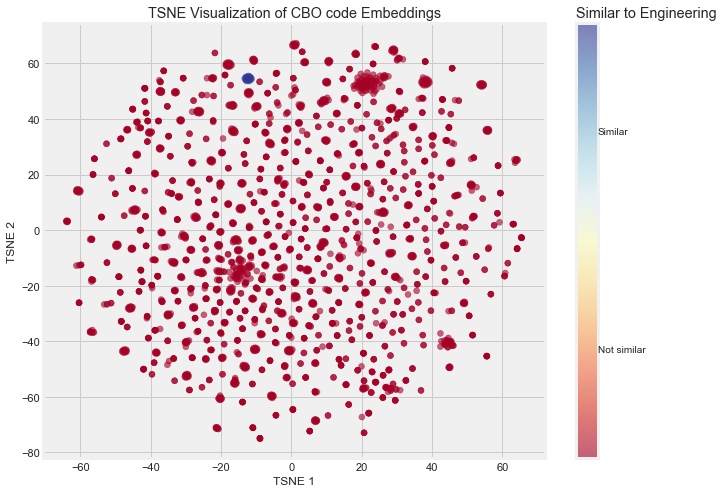

In [343]:
plt.figure(figsize = (10, 8))

# Plot embedding
plt.scatter(cbo_r[:, 0], cbo_r[:, 1], 
            c = ints, cmap = plt.cm.RdYlBu,alpha=0.6)

# Add colorbar and appropriate labels
cbar = plt.colorbar()
cbar.set_ticks([])
for j, lab in enumerate(gen):
    cbar.ax.text(1, (2 * j + 1) / ((2) * 2), lab, ha='left', va='center')
cbar.ax.set_title('Similar to Engineering', loc = 'left')


plt.xlabel('TSNE 1'); plt.ylabel('TSNE 2'); plt.title('TSNE Visualization of CBO code Embeddings');

## CBO codes Embeddings by Groups



In [344]:
groups = data_similarity_comparison[['cbo_idx1','cbo1_group']].drop_duplicates()

In [345]:
ints, gen = pd.factorize(groups.cbo1_group)
ints

array([0, 0, 0, ..., 9, 9, 9], dtype=int64)

Finally, we can plot the embedding colored by the genre

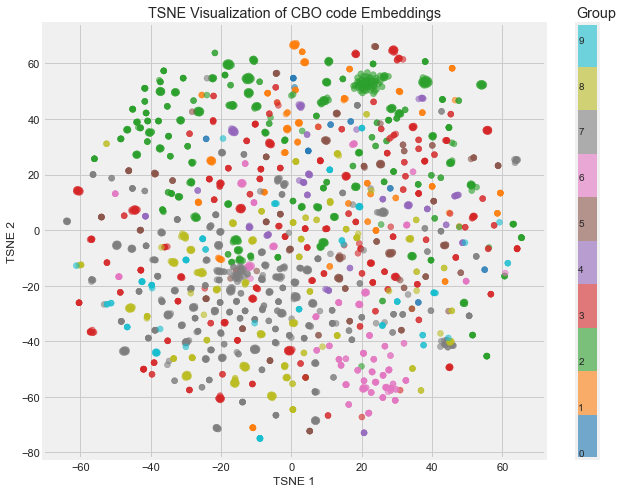

In [352]:
plt.figure(figsize = (10, 8))

# Plot embedding
plt.scatter(cbo_r[:, 0], cbo_r[:, 1], 
            c = ints, cmap = plt.cm.tab10,alpha = 0.6)

# Add colorbar and appropriate labels
cbar = plt.colorbar()
cbar.set_ticks([])
for j, lab in enumerate(gen):
    cbar.ax.text(1, (19 * j + 2) / ((10) * 2), lab, ha='left', va='center')
cbar.ax.set_title('Group', loc = 'left')


plt.xlabel('TSNE 1'); plt.ylabel('TSNE 2'); plt.title('TSNE Visualization of CBO code Embeddings');

In [354]:
np.savetxt('../embeddings/cbo_embedding.tsv', cbo_weights_class, delimiter='\t')


In [355]:
cbo_embedding = np.loadtxt('../embeddings/cbo_embedding.tsv', delimiter = '\t')
cbo_embedding.shape

(2641, 50)